# Ground-roll attenuation models CV

CV is for "cross-validation". Here we consider two datasets, named A and B. Each dataset consists of raw field seismogram and seismogram with reduced ground-rolls. We will use one dataset for training and consider model performance with respect to the second dataset. We will also compare models trained from random state and from pretrained state.

## Content
* [Trained on A. Performance on A.](#Trained-on-A.-Performance on A.)
* [Trained on A. Performance on B.](#Trained-on-A.-Performance-on-B.)
* [Trained on B. Performance on B.](#Trained-on-B.-Performance-on-B.)
* [Trained on B. Performance on A.](#Trained-on-B.-Performance-on-A.)
* [Pretrained on B. Trained on A. Performance on A.](#Pretrained-on-B.-Trained-on-A.-Performance-on-A.)

## Trained on A. Performance on A.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append('..')

from geolog.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from geolog.batchflow.models.tf import UNet

from geolog.src import SeismicBatch, KNNIndex, FieldIndex, spectrum_plots

%env CUDA_VISIBLE_DEVICES=3

path_raw = '/notebooks/data/Orekhovskaya_noise_dataset/D01_for_Lift.sgy'
path_lift = '/notebooks/data/Orekhovskaya_noise_dataset/D02_Lift_SP.sgy'

index = FieldIndex((KNNIndex(name='raw', n_neighbors=3, path=path_raw)
                    .merge(KNNIndex(name='lift', n_neighbors=3, path=path_lift))))

env: CUDA_VISIBLE_DEVICES=3


Model evaluation pipeline:

In [2]:
model_config = {
    "build": False,
    "load": {"path": './unet_3knn_model'},
}

def make_data(batch, **kwagrs):
    x = np.transpose(np.stack(batch.raw), (0, 2, 1))
    return {"feed_dict": {'x': x}}

predict_pipeline = (Pipeline()
                    .load(components=('raw', 'lift'), tslice=np.arange(2000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

INFO:tensorflow:Restoring parameters from ./unet_3knn_model/model-2856


Define a test subset:

In [3]:
i = 5
test_index = KNNIndex(index.create_subset(index.indices[i:i + 1]))
test_set = Dataset(test_index, SeismicBatch)

if index.indices[i:i + 1] in [3467, 3384, 3424, 3383, 3452, 3406, 3388, 3432, 3377, 3407, 3445,
            3386, 3423, 3450, 3441]:
    print('Index in train subset!')

Run the inference pipeline on the test subset:

In [4]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=len(test_set), n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]


Arrange results:

In [5]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)
raw = np.vstack(np.hstack(predict_pipeline.get_variable("raw")))[::3]
lift = np.vstack(np.hstack(predict_pipeline.get_variable("lift")))[::3]

ML and RAW seismograms comparison:

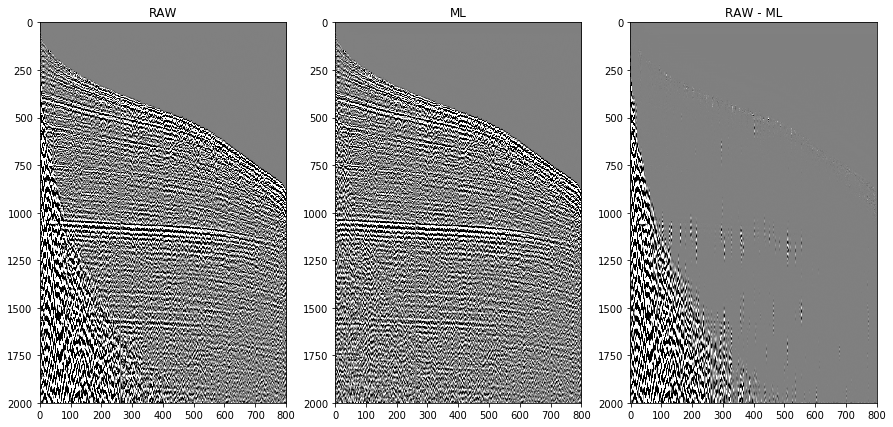

In [7]:
cv = 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('ML')
ax[2].imshow((raw - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('RAW - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

ML and LIFT seismograms comparison:

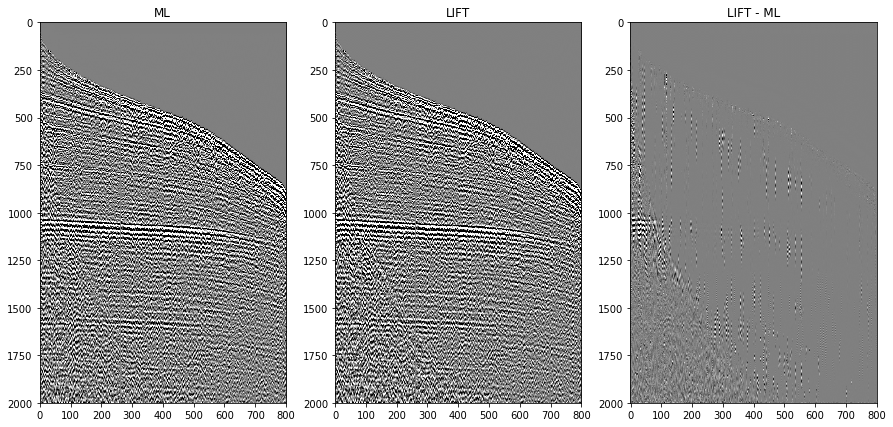

In [6]:
cv = 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('ML')
ax[1].imshow(lift.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('LIFT')
ax[2].imshow((lift - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('LIFT - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

Correlation between ML and LIFT traces:

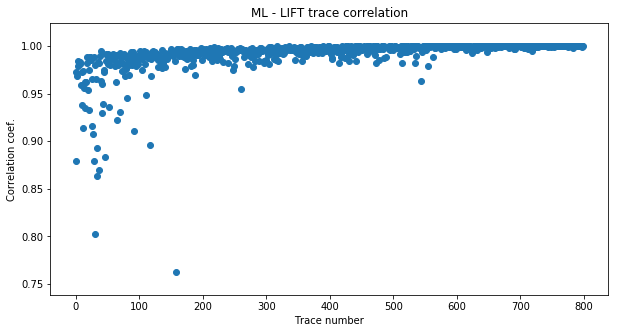

In [9]:
corr = [stats.pearsonr(res[i], lift[i])[0] for i in range(len(res))]

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(corr)), corr)
plt.title("ML - LIFT trace correlation")
plt.xlabel('Trace number'), plt.ylabel('Correlation coef.')
plt.show()

Select regions with and without ground-rolls in the seismogram and compare ML and LIFT spectrums:

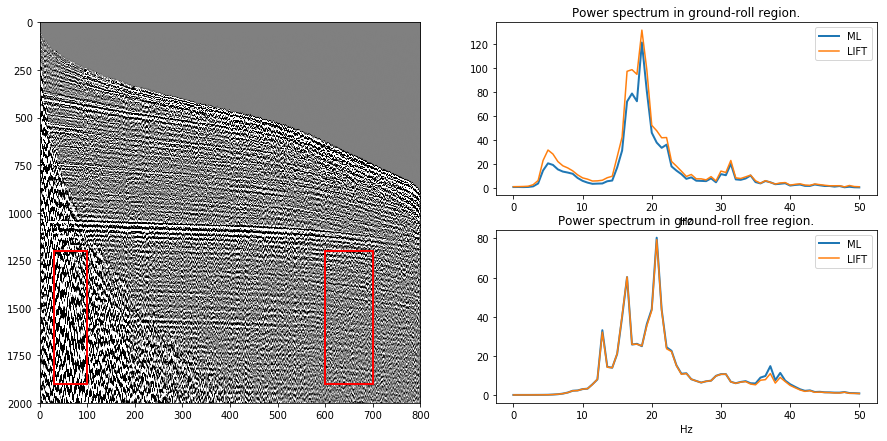

In [7]:
dw_noise = (slice(30, 100), slice(1200, 1900))
dw_signal = (slice(600, 700), slice(1200, 1900))

spectrum_plots(dw_noise, dw_signal, raw, res, lift,
               cv=0.1, max_freq=50, figsize=(15, 7))

## Trained on A. Performance on B.

In [9]:
path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = FieldIndex((KNNIndex(name='raw', n_neighbors=3, path=path_raw)
                    .merge(KNNIndex(name='lift', n_neighbors=3, path=path_lift))))

Define a test subset:

In [10]:
i = 50
test_index = KNNIndex(index.create_subset(index.indices[i:i + 1]))
test_set = Dataset(test_index, SeismicBatch)

Run the inference pipeline on the test subset:

In [11]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=len(test_set), n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]


Arrange results:

In [12]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)[:1000]
raw = np.vstack(np.hstack(predict_pipeline.get_variable("raw")))[::3][:1000]
lift = np.vstack(np.hstack(predict_pipeline.get_variable("lift")))[::3][:1000]

ML and RAW seismograms comparison:

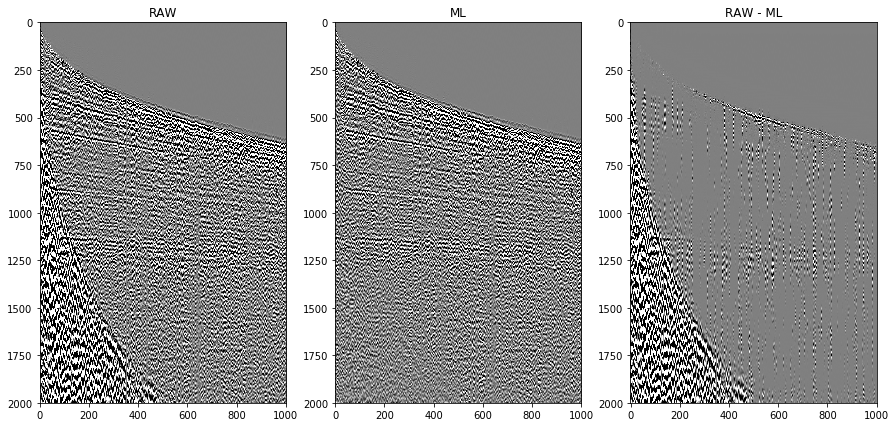

In [13]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('ML')
ax[2].imshow((raw - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('RAW - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

ML and LIFT seismograms comparison:

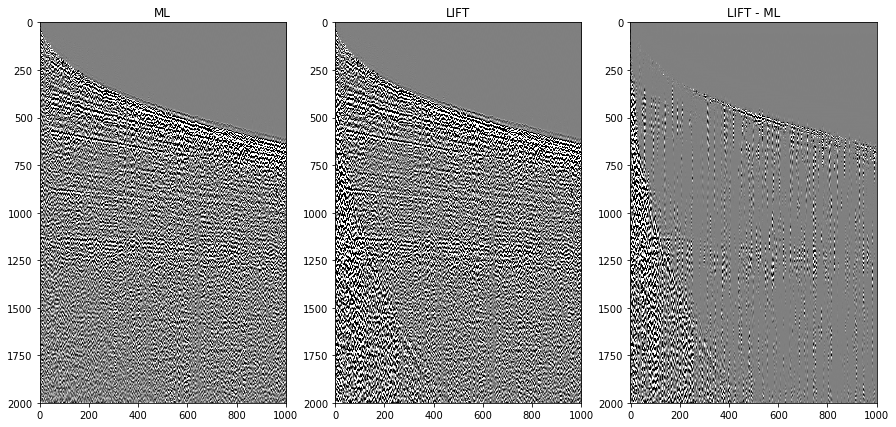

In [14]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('ML')
ax[1].imshow(lift.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('LIFT')
ax[2].imshow((lift - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('LIFT - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

Correlation between ML and LIFT traces:

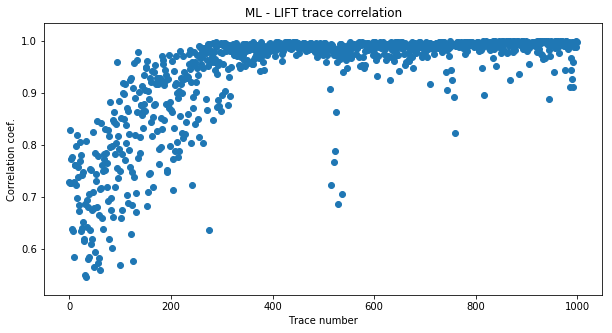

In [15]:
corr = [stats.pearsonr(res[i], lift[i])[0] for i in range(len(res))]

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(corr)), corr)
plt.title("ML - LIFT trace correlation")
plt.xlabel('Trace number'), plt.ylabel('Correlation coef.')
plt.show()

Select regions with and without ground-rolls in the seismogram and compare ML and LIFT spectrums:

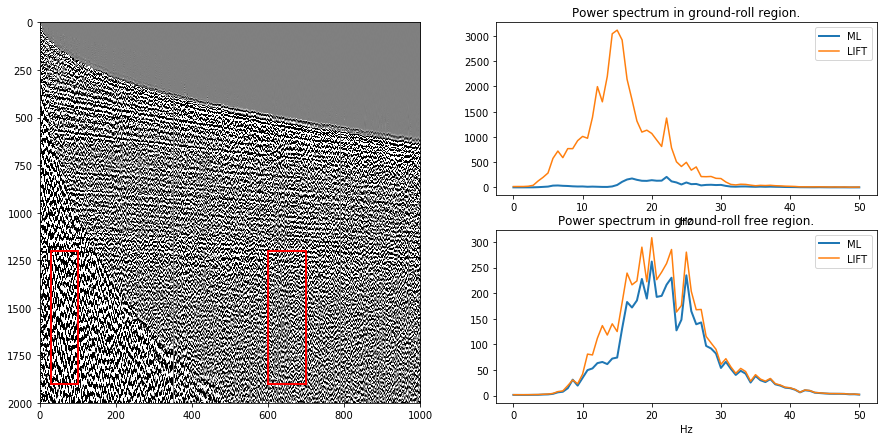

In [16]:
dw_noise = (slice(30, 100), slice(1200, 1900))
dw_signal = (slice(600, 700), slice(1200, 1900))

spectrum_plots(dw_noise, dw_signal, raw, res, lift,
               cv=0.1, max_freq=50, figsize=(15, 7))

## Trained on B. Performance on B.

In [17]:
path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = FieldIndex((KNNIndex(name='raw', n_neighbors=3, path=path_raw)
                    .merge(KNNIndex(name='lift', n_neighbors=3, path=path_lift))))

Update predict pipeline:


In [18]:
model_config = {
    "build": False,
    "load": {"path": './unet_3knn_3000_model'},
}

def make_data(batch, **kwagrs):
    x = np.transpose(np.stack(batch.raw), (0, 2, 1))
    return {"feed_dict": {'x': x}}

predict_pipeline = (Pipeline()
                    .load(components=('raw', 'lift'), tslice=np.arange(3000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

INFO:tensorflow:Restoring parameters from ./unet_3knn_3000_model/model-3240


Define a test subset:

In [19]:
i = 50
test_index = KNNIndex(index.create_subset(index.indices[i:i + 1]))
test_set = Dataset(test_index, SeismicBatch)

Run the inference pipeline on the test subset:

In [20]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=20, n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

 99%|█████████▉| 172/173 [00:06<00:00, 26.81it/s]


Arrange results:

In [21]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)[:2000]
raw = np.vstack(np.hstack(predict_pipeline.get_variable("raw")))[::3][:2000]
lift = np.vstack(np.hstack(predict_pipeline.get_variable("lift")))[::3][:2000]

ML and RAW seismograms comparison:

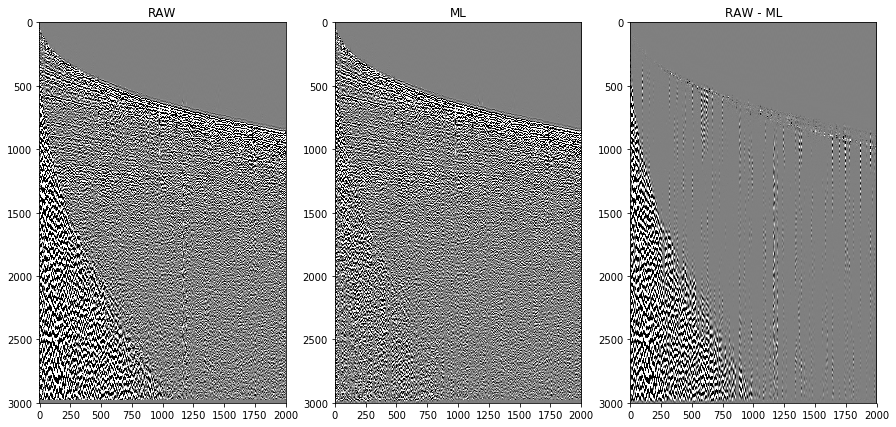

In [22]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('ML')
ax[2].imshow((raw - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('RAW - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

ML and LIFT seismograms comparison:

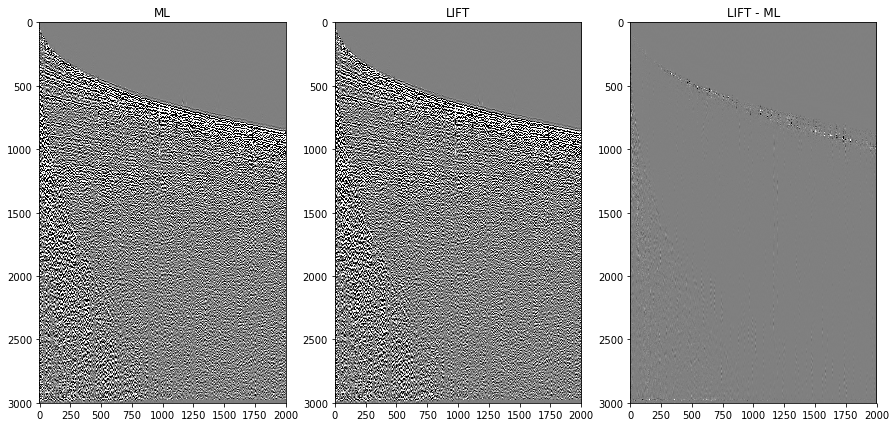

In [23]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('ML')
ax[1].imshow(lift.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('LIFT')
ax[2].imshow((lift - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('LIFT - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

Correlation between ML and LIFT traces:

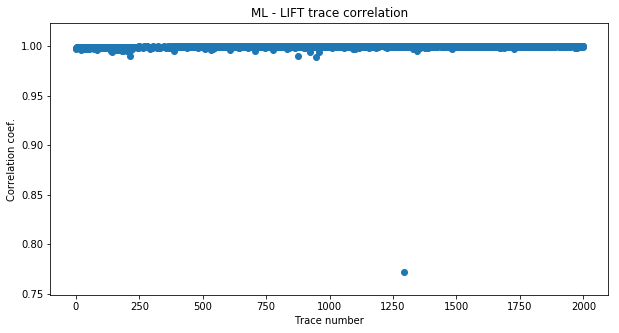

In [24]:
corr = [stats.pearsonr(res[i], lift[i])[0] for i in range(len(res))]

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(corr)), corr)
plt.title("ML - LIFT trace correlation")
plt.xlabel('Trace number'), plt.ylabel('Correlation coef.')
plt.show()

Select regions with and without ground-rolls in the seismogram and compare ML and LIFT spectrums:

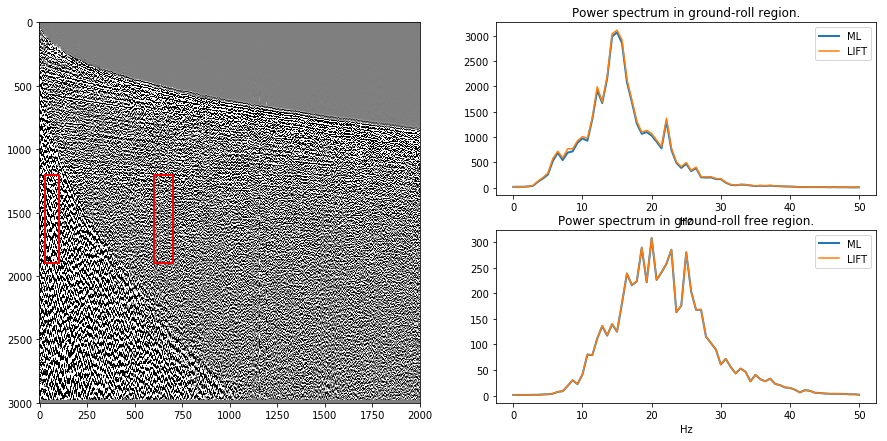

In [25]:
dw_noise = (slice(30, 100), slice(1200, 1900))
dw_signal = (slice(600, 700), slice(1200, 1900))

spectrum_plots(dw_noise, dw_signal, raw, res, lift,
               cv=0.1, max_freq=50, figsize=(15, 7))

## Trained on B. Performance on A.

In [27]:
path_raw = '/notebooks/data/Orekhovskaya_noise_dataset/D01_for_Lift.sgy'
path_lift = '/notebooks/data/Orekhovskaya_noise_dataset/D02_Lift_SP.sgy'

index = FieldIndex((KNNIndex(name='raw', n_neighbors=3, path=path_raw)
                    .merge(KNNIndex(name='lift', n_neighbors=3, path=path_lift))))

Update predict pipeline:


In [28]:
model_config = {
    "build": False,
    "load": {"path": './unet_3knn_3000_model'},
}

def make_data(batch, **kwagrs):
    x = np.transpose(np.stack(batch.raw), (0, 2, 1))
    return {"feed_dict": {'x': x}}

predict_pipeline = (Pipeline()
                    .load(components=('raw', 'lift'), tslice=np.arange(2000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .pad_traces(src=('raw', 'lift'), dst=('raw', 'lift'),
                                pad_width=(0, 1000), mode='constant')
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

INFO:tensorflow:Restoring parameters from ./unet_3knn_3000_model/model-3240


Define a test subset:

In [29]:
i = 5
test_index = KNNIndex(index.create_subset(index.indices[i:i + 1]))
test_set = Dataset(test_index, SeismicBatch)

Run the inference pipeline on the test subset:

In [30]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=len(test_set), n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]


Arrange results:

In [31]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)[:, :2000]
raw = np.vstack(np.hstack(predict_pipeline.get_variable("raw")))[::3, :2000]
lift = np.vstack(np.hstack(predict_pipeline.get_variable("lift")))[::3, :2000]

ML and RAW seismograms comparison:

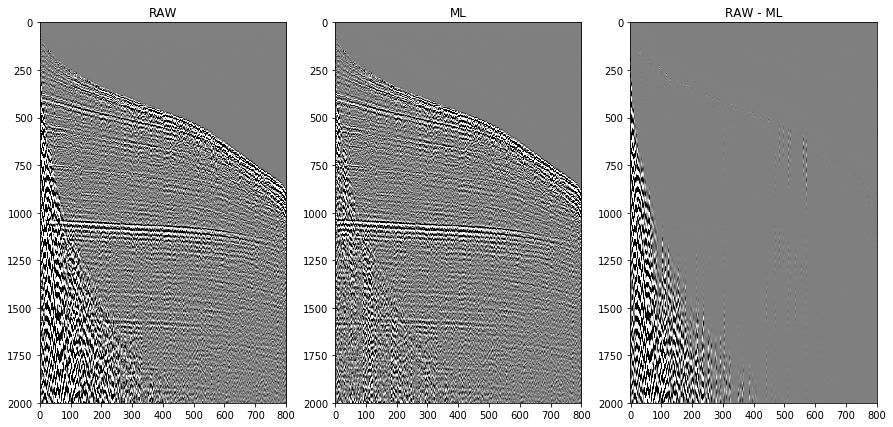

In [32]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('ML')
ax[2].imshow((raw - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('RAW - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

ML and LIFT seismograms comparison:

In [33]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('ML')
ax[1].imshow(lift.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('LIFT')
ax[2].imshow((lift - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('LIFT - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

Correlation between ML and LIFT traces:

In [34]:
corr = [stats.pearsonr(res[i], lift[i])[0] for i in range(len(res))]

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(corr)), corr)
plt.title("ML - LIFT trace correlation")
plt.xlabel('Trace number'), plt.ylabel('Correlation coef.')
plt.show()

Select regions with and without ground-rolls in the seismogram and compare ML and LIFT spectrums:

In [35]:
dw_noise = (slice(30, 100), slice(1200, 1900))
dw_signal = (slice(600, 700), slice(1200, 1900))

spectrum_plots(dw_noise, dw_signal, raw, res, lift,
               cv=0.1, max_freq=50, figsize=(15, 7))

## Pretrained on B. Trained on A. Performance on A.

In [40]:
path_raw = '/notebooks/data/Orekhovskaya_noise_dataset/D01_for_Lift.sgy'
path_lift = '/notebooks/data/Orekhovskaya_noise_dataset/D02_Lift_SP.sgy'

index = FieldIndex((KNNIndex(name='raw', n_neighbors=3, path=path_raw)
                    .merge(KNNIndex(name='lift', n_neighbors=3, path=path_lift))))

In [37]:
model_config = {
    "build": False,
    "load": {"path": './unet_3knn_pretrained_3000_model'},
}

def make_data(batch, **kwagrs):
    x = np.transpose(np.stack(batch.raw), (0, 2, 1))
    return {"feed_dict": {'x': x}}

predict_pipeline = (Pipeline()
                    .load(components=('raw', 'lift'), tslice=np.arange(2000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .pad_traces(src=('raw', 'lift'), dst=('raw', 'lift'),
                                pad_width=(0, 1000), mode='constant')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

INFO:tensorflow:Restoring parameters from ./unet_3knn_pretrained_3000_model/model-5620


Define a test subset:

In [38]:
i = 5
test_index = KNNIndex(index.create_subset(index.indices[i:i + 1]))
test_set = Dataset(test_index, SeismicBatch)

if index.indices[i:i + 1] in [3467, 3384, 3424, 3383, 3452, 3406, 3388, 3432, 3377, 3407, 3445,
            3386, 3423, 3450, 3441]:
    print('Index in train subset!')

Run the inference pipeline on the test subset:

In [41]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=len(test_set), n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]


Arrange results:

In [42]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)[:, :2000]
raw = np.vstack(np.hstack(predict_pipeline.get_variable("raw")))[::3, :2000]
lift = np.vstack(np.hstack(predict_pipeline.get_variable("lift")))[::3, :2000]

ML and RAW seismograms comparison:

In [43]:
cv = 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('ML')
ax[2].imshow((raw - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('RAW - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

ML and LIFT seismograms comparison:

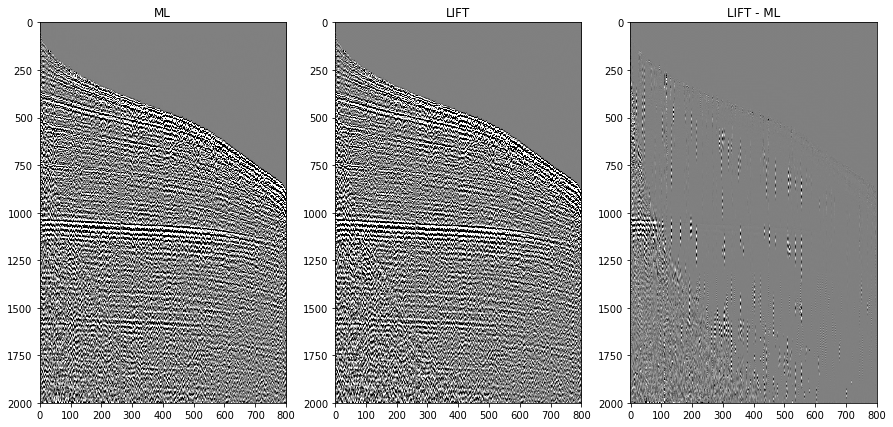

In [44]:
cv = 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('ML')
ax[1].imshow(lift.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].set_title('LIFT')
ax[2].imshow((lift - res).T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].set_title('LIFT - ML')
[f.set_aspect('auto') for f in ax]
plt.show()

Correlation between ML and LIFT traces:

In [45]:
corr = [stats.pearsonr(res[i], lift[i])[0] for i in range(len(res))]

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(corr)), corr)
plt.title("ML - LIFT trace correlation")
plt.xlabel('Trace number'), plt.ylabel('Correlation coef.')
plt.show()

Select regions with and without ground-rolls in the seismogram and compare ML and LIFT spectrums:

In [46]:
dw_noise = (slice(30, 100), slice(1200, 1900))
dw_signal = (slice(600, 700), slice(1200, 1900))

spectrum_plots(dw_noise, dw_signal, raw, res, lift,
               cv=0.1, max_freq=50, figsize=(15, 7))

Done!